# Wind Loading Analysis for the EB Ground Station

## Intro

### Explanations

#### Resources
* [Average daily wind data for Portland][AWND]
* Free historical weather data on [Wunderground]. 
    * Note: It only displays the data one year at a time, at most... Anyone want to write a little scraping script?
* [NOAA report][2007 report] on the 2007 storm. (Costal data)
* There's this [city-data thread] where someone claims that 116 mph winds were observed on the Morrison bridge during the Columbus Day storm. Sadly, they do not cite any sources...

[AWND]: http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.DAILY/.FSOD/WBAN+24229+VALUE/.AWND/
[Wunderground]: https://www.wunderground.com/history/airport/KPDX/
[2007 report]: http://www.wrh.noaa.gov/pqr/paststorms/20071203/tabular_obs.php#winds
[city-data thread]: http://www.city-data.com/forum/weather/621044-what-highest-winds-ever-recorded-your-2.html

#### TODO
* get the missing parameters
    * get the drag coefficient for the antenna/station (with ice)
        * you can estimate this if you know the dimensions of the antenna. Just model it as a whole bunch of cylinders. The Cd of a cylinder is well known.
        * Slight annoyance: C_d is a function of Re. The smallest conductors on the antenna will have a different Re than the mast, for example. Buuuuut, a factor of 2 or 3 change in Re usually corresponds to a very small change in C_d. (should be confirmed)
    * get the maximum expected wind speed
    * get the frontal area for the antenna, with ice
        * It would also be neat if we could calculate the corresponding ice thickness.
    * get an acceptable factor of safety on the wind speed
    * get the actual value for the center of mass 
        * get the mass of the blocks
        * get the mass of the tubes
        * get the mass of the antenna/equipment (with ice)
* put things in terms of initial parameters
    * CoP in terms of the station dimensions
    * wind loading in terms of speed and Cd
* make a non-shitty version of the loading diagram

#### Problem Description

##### Failure Mode: Tipping
We want to know how heavy the feet of the ground station need to be in order to **keep it from tipping over in high winds.**  
We are assuming the worst-case is that antenna will be covered in ice during a wind storm. The criterion for tipping is when the moment due to wind is equal and opposite to the moment due to gravity. 

I'm choosing the foot weight as the "trim" variable, since it's a lot easier to just swap out some larger blocks than to find out, say, that we need to redesign the ground station for a larger mast diameter.

##### Failure Mode: Bending
We also want to know the necessary size and material of the mast, so that it **doesn't bend.**  
Stress analysis will be done in SolidWorks.

#### Solution
##### Design Process 
1. choose arbitrary dimensions for the ground station
2. find the worst-case loading
3. determine if any part of the ground station will yield
    * If it does, go to 1.
4. determine if the ground station will tip over
    * If it will, add weight to the feet.

##### Information I/O:
* Empirical C_d data: (profile of antenna conductors, typical conductor diameter, ripped plots from Munson book, wind speed) -> approximate C_d for the whole antenna (probably about 1.2) 
* Drag equation: (wind speed, air density, C_d, frontal area) -> drag on antenna
* (same collection of variables as above) -> drag on mast, legs
* (leg dimensions, material) -> leg CoM
* 2nd law for moments: (CoMs of all components, masses of all components, drag on antenna) -> necessary foot mass to prevent tipping

### Setup

#### Imports

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import sympy as sym
import pandas as pd
import magnitude as mag
from magnitude import mg
mag.new_mag('lbm', mag.Magnitude(0.45359237, kg=1))
mag.new_mag('lbf', mg(4.4482216152605, 'N'))
mag.new_mag('mph', mg(0.44704, 'm/s'))
from IPython.display import display, Markdown, Latex
def printBig(*message): # like print(), but with header2 formatting
    display(Markdown( '## ' + ' '.join([str(x) for x in message]) ))
# drag force:
def dragf(rho, A, Cd, v): return(mg(1/2)*rho*A*Cd*v**2)
# second area moment of an annulus:
def I_annulus(OD, ID): return(  mg(np.pi/4)*( (OD/mg(2))**4 - (ID/mg(2))**4 )  )
# area of an annulus:
def annularArea(ID, OD): return(mg(np.pi)*(OD**2/mg(4)-ID**2/mg(4)))
print(sys.version)
%matplotlib inline
sym.init_printing()

3.4.3 (default, Nov 17 2016, 01:08:31) 
[GCC 4.8.4]


#### Diagram

![](loadingDiagram.png)

#### input parameters

In [2]:
FS= mg(1)                           # factor of safety (NOT SURE IF BUILDING CODES HAVE ONE BUILT IN)

##### physical quantities

In [3]:
g= mg(9.81,'m/s2')                  # gravitational acceleration
rho_air= mg(1.225,'kg/m3')          # density of air at 0 C
mu_air= mg(1.7e-5,'Pa s')           # dynamic viscosity of air at 0 C
nu_air= mu_air/rho_air              # kinematic viscosity of air at 0 C
rho_steel= mg(7.8e3,'kg/m3')        # density of steel
rho_al= mg(2.7e3,'kg/m3')           # density of aluminum
rho_fg= mg(1520,'kg/m3')            # density of fiberglass
rho_concrete= mg(2300,'kg/m3')      # density of concrete
sigma_y_al= mg(276,'MPa')           # tensile yield strength of 6061-T6 aluminum

##### ground station parameters

In [4]:
Cd= mg(1.2)                         # Drag coefficient of a cylinder/antenna at relevant speeds, (THIS IS A GUESS)
# Fg= mg(300,'lbf')                   # weight of the ground station (THIS IS A GUESS)
v_wind_actual= mg(100,'mph')        # max expexted wind speed (WHAT'S THE JUSTIFICATION HERE?)
v_wind= v_wind_actual*FS            # max expexted wind speed (WHAT'S THE JUSTIFICATION HERE?)
# legs
Lxy_leg= mg(77,'inch')              # length of a leg projected in the XY plane
L_leg= mg(78.75,'inch')             # length of a leg
L_truss= mg(48.75,'inch')           # length of the beam fixing a leg

# feet
Lxy_foot= mg(18.5,'inch')           # side length of the foot's footprint
Lz_foot= mg(6,'inch')               # height of the feet

# antennas
A_70cm= mg(4.0,'ft2')               # frontal area of the 70 cm antenna
# A_70cm= mg(0,'ft2')
m_70cm= mg(7.5,'lbm')               # mass of the 70 cm antenna
A_2m= mg(5.0,'ft2')                 # frontal area of the 2 m antenna
# A_2m= mg(0,'ft2')
m_2m= mg(9.5, 'lbm')                # mass fo the 2 m antenna

# mast
L_mast= mg(180,'inch')              # length of the mast
OD_mast= mg(1.9,'inch')             # outer diameter of the mast
ID_mast= mg(1.48,'inch')            # inner diameter of the mast

# cross boom
OD_crossBoom= mg(2.0,'inch')        # outer diameter of the cross boom
ID_crossBoom= mg(1.5,'inch')        # inner diameter of the cross boom
L_crossBoom= mg(60+60+10.75,'inch') # length of the cross boom
rho_crossBoom= rho_fg               # density of the cross boom

# legs
OD_leg= mg(1.0,'inch')              # outer diameter of the legs
ID_leg= OD_leg-mg(2*0.2,'inch')     # inner diameter of the legs (GUESSING A 0.2" wall)

#### secondary parameters

In [5]:
# geometry
# L_leg^2 = Lz_leg^2 + Lxy_leg^2
Lz_leg= np.sqrt(L_leg**2 - Lxy_leg**2)
Lx_leg= Lxy_leg*mg(np.cos(np.pi/6)) # length of a leg projected in the X axis
Ly_leg= Lxy_leg*mg(np.cos(np.pi/3)) # length of a leg projected in the X axis

# frontal areas
A_mast= L_mast*OD_mast
A_crossBoom= L_crossBoom*OD_crossBoom
A_legs= mg(2)*(Lx_leg*OD_leg) +(Lz_leg*OD_leg)
A_total= A_70cm+A_2m+A_mast+A_crossBoom+A_legs

# masses
m_foot= rho_concrete*Lxy_foot**2*Lz_foot
m_mast= rho_al*L_mast*annularArea(ID=ID_mast, OD=OD_mast)
m_leg= rho_steel*L_leg*annularArea(ID=ID_leg, OD=OD_mast)
m_crossBoom= rho_fg*L_crossBoom*annularArea(ID=ID_crossBoom, OD=OD_crossBoom)
m_structure= m_mast+mg(3)*m_leg+m_crossBoom+m_70cm+m_2m

# centers of mass
Lz_CoM_70cm= L_mast
Lz_CoM_2m= L_mast
Lz_CoM_mast= L_mast/mg(2)
Lz_CoM_foot= Lz_foot/mg(2)
Lz_CoM_leg= Lz_foot+Lz_leg/mg(2)
Lz_CoM_crossBoom= L_mast

In [6]:
print(
    'area contributions', 
    '70cm:', A_70cm.ounit('m2'), 
    '2m:', A_2m.ounit('m2'), 
    'mast:', A_mast, 
    'cross boom:', A_crossBoom, 
    'legs:', A_legs, 
    'total:', A_total, 
    sep='\n')

area contributions
70cm:
0.3716 m2
2m:
0.4645 m2
mast:
0.2206 m2
cross boom:
0.1687 m2
legs:
0.0967 m2
total:
1.3222 m2


## Calculations

I'm counting the mass of the feet separately, since they aren't rigidly attached to the rest of the ground station. I assume that if the station tips, it will rotate around the pivots on two of the feet. Meanwhile the third (upstream) foot would dangle from the pivot, keeping its CoM directly below the pivot. So, unlike all the other components, I don't assume that the CoM of the feet is centered on the mast. I take it to be the mass of a single foot on the upstream (-X) leg. 

### Tipping

Technically, I'm breaking the right hand rule. I'm using the -Y axis to be the direction of positive rotation. So, on the diagram, a positive rotation would be counter-clockwise. This is just because I'm used to thinking of positive rotation as "out-of-the-page", and the -Y axis is out-of-the-page on the diagram.

#### find drag, CoP, CoM

In [7]:
# center of pressure for the whole station
# assuming the CoP for each element is at the CoM (no lift on elem, constant density of elem)
Lz_CoP= (
             A_mast*Lz_CoM_mast
            +A_70cm*Lz_CoM_70cm
            +A_2m*Lz_CoM_2m
            +A_crossBoom*Lz_CoM_crossBoom
            +A_legs*Lz_CoM_leg
        )/A_total
# height of the CoM of the whole station
# (only useful for finding critical tipping angle)
Lz_CoM_total= (
                 Lz_CoM_mast*m_mast
                +Lz_CoM_2m*m_2m
                +Lz_CoM_70cm*m_70cm
                +Lz_CoM_crossBoom*m_crossBoom
                +Lz_CoM_leg*m_leg*mg(3)
            )/m_structure
# drag on the station
#D_wind= mg(1/2)*rho_air*A_total*Cd*v_wind**2
D_wind= dragf(rho=rho_air, A=A_total, Cd=Cd, v=v_wind)

#### balance moments and find required ballast

In [8]:
# Moments exerted on the station
M_wind= -D_wind*(Lz_CoP-Lz_foot) # negative sign from CW direction
M_structure= m_structure*g*Lx_leg
M_foot= m_foot*g*(Lx_leg+Lxy_leg)
# 0 == M_wind + M_structure + M_foot + M_balast
M_ballast= -M_wind-M_structure-M_foot
# M_ballast == m_ballast*g*(Lx_leg+Lxy_leg)
m_ballast= M_ballast/g/(Lx_leg+Lxy_leg) # ballast on the foot
# m_ballast= M_ballast/g/(Lx_leg) # ballast on the mast

#### bending on a welded mast
(probably not relevant)

In [9]:
# # I= pi/4*(r_o^2 - r_i^2)
# I_mast= I_annulus(OD= OD_mast, ID= ID_mast)
# M_bending= D_wind*(Lz_CoP - Lz_leg)
# # sigma_max= M*y/I
# # max stress in the mast, assuming it's anchored at the height of the foot
# sigma_max_mast= M_bending*(OD_mast/mg(2))/I_mast
# print(
#     'tension from bending, if the mast is welded at the height of the feet:', 
#     sigma_max_mast.ounit('MPa')
# )
# print('tensile yield stress of the mast:', sigma_y_al.ounit('MPa'))

#### report results

In [10]:
print('m_ballast:', m_ballast.ounit('lbm'))
if (m_ballast.val <= 0):
    print('No ballast needed. (Wind will not tip station)')
else:
    print('mass of the required ballast per foot:', m_ballast.ounit('lbm'))
    print('mass of a foot (for comparison):', m_foot.ounit('lbm '))

m_ballast: 175.0440 lbm
mass of the required ballast per foot: 175.0440 lbm
mass of a foot (for comparison): 170.6310 lbm


### Bending

#### determine the loads applied to the mast

F_p is a point load. F_d is a distributed load.

Drag on the legs is beared equally by the feet and mast (by symmetry)
If I ever add in the calculation for the drag on the armpit beams, 
I'll need to add half their drag to this number for the same reason.
And, I'll probably just assume that they have no reaction forces, since they
would make things statically indeterminate, which sucks.

Use 2nd law for forces and moments to get the reaction forces... Should probably make a diagram explaining where these loads are applied.

In [11]:
F_p_legsDrag= mg(1/2)*dragf(rho=rho_air, A=A_legs, Cd=Cd, v=v_wind)
F_p_boom= dragf(
                    rho=rho_air, Cd=Cd, v=v_wind,
                    A= A_70cm+A_2m+A_crossBoom
                    )
F_d_mast= dragf(rho=rho_air, Cd=Cd, A=A_mast, v=v_wind) # distributed over the mast

# about the base:
# sum(M) == 0 == (F_p_legsReact-F_p_legsDrag)*Lz_leg - F_p_boom*L_mast - F_d_mast*L_mast/2
# sum(F) == 0 == -F_p_legsReact + F_p_legsDrag + F_p_boom + F_p_baseReact + F_d_mast
F_p_legsReact= mg(1)/Lz_leg*( F_p_boom*L_mast + F_d_mast*L_mast/mg(2) ) + F_p_legsDrag
F_p_baseReact= F_p_legsReact - F_p_legsDrag - F_p_boom + F_d_mast

#### symbolically find loading on the mast

In [21]:
# x = sym.symbols('x')
# print(F_p_boom.ounit('N'))
# # load per length, as a function of length along the mast:
# Fdist_expr_mast= F_d_mast/L_mast \
#     + F_p_baseReact*mg(sym.DiracDelta(x),'/m') \
#     + (-F_p_legsReact+F_p_legsDrag)*mg(sym.DiracDelta(x-Lz_leg.toval(ounit='m')),'/m') \
#     + F_p_boom*mg(sym.DiracDelta(x-L_mast.toval(ounit='m')),'/m')
# print('load distribution expression:\n', Fdist_expr_mast.toval(ounit='N/m'), 'N/m')
# # shear load, as a function of length along the mast:
# F_expr_mast= mg(sym.integrate(Fdist_expr_mast.toval(ounit='N/m'), x),'N')
# print('shear load expression:\n', F_expr_mast.toval(ounit='N'), 'N')
# # bending moment, as a function of length along the mast:
# M_expr_mast= mg(sym.integrate(F_expr_mast.toval(ounit='N'),x), 'N m')
# print('bending load expression:\n', M_expr_mast.toval(ounit='N m'), 'N m')

1475.9634 N
load distribution expression:
 16707.1013383692*DiracDelta(x) + 1475.96342807447*DiracDelta(x - 4.572) - 17858.9687841635*DiracDelta(x - 0.419340461319915) + 70.8871352318976 N/m
shear load expression:
 70.8871352318976*x + 16707.1013383692*Heaviside(x) + 1475.96342807447*Heaviside(x - 4.572) - 17858.9687841635*Heaviside(x - 0.419340461319915) N
bending load expression:
 35.4435676159488*x**2 + 16707.1013383692*x*Heaviside(x) + 1475.96342807447*Piecewise((0, 0.218722659667542*Abs(x) < 1), (4.572*meijerg(((2, 1), ()), ((), (1, 0)), 0.218722659667542*x), True)) - 17858.9687841635*Piecewise((0, 2.38469714287146*Abs(x) < 1), (0.419340461319915*meijerg(((2, 1), ()), ((), (1, 0)), 2.38469714287146*x), True)) N m


In [21]:
x = sym.symbols('x')
# load per length, as a function of length along the mast:
Fdist_expr_mast= F_d_mast.toval('N')/L_mast.toval('m') \
    + F_p_baseReact.toval('N')*sym.DiracDelta(x) \
    + (-F_p_legsReact.toval('N')+F_p_legsDrag.toval('N'))*sym.DiracDelta(x-Lz_leg.toval(ounit='m')) \
    + F_p_boom.toval('N')*sym.DiracDelta(x-L_mast.toval(ounit='m'))
print('load distribution expression:\n', Fdist_expr_mast.toval(ounit='N/m'), 'N/m')
# shear load, as a function of length along the mast:
F_expr_mast= mg(sym.integrate(Fdist_expr_mast.toval(ounit='N/m'), x),'N')
print('shear load expression:\n', F_expr_mast.toval(ounit='N'), 'N')
# bending moment, as a function of length along the mast:
M_expr_mast= mg(sym.integrate(F_expr_mast.toval(ounit='N'),x), 'N m')
print('bending load expression:\n', M_expr_mast.toval(ounit='N m'), 'N m')

1475.9634 N
load distribution expression:
 16707.1013383692*DiracDelta(x) + 1475.96342807447*DiracDelta(x - 4.572) - 17858.9687841635*DiracDelta(x - 0.419340461319915) + 70.8871352318976 N/m
shear load expression:
 70.8871352318976*x + 16707.1013383692*Heaviside(x) + 1475.96342807447*Heaviside(x - 4.572) - 17858.9687841635*Heaviside(x - 0.419340461319915) N
bending load expression:
 35.4435676159488*x**2 + 16707.1013383692*x*Heaviside(x) + 1475.96342807447*Piecewise((0, 0.218722659667542*Abs(x) < 1), (4.572*meijerg(((2, 1), ()), ((), (1, 0)), 0.218722659667542*x), True)) - 17858.9687841635*Piecewise((0, 2.38469714287146*Abs(x) < 1), (0.419340461319915*meijerg(((2, 1), ()), ((), (1, 0)), 2.38469714287146*x), True)) N m


#### 

16707.1013383692*DiracDelta(x) + 1475.96342807447*DiracDelta(x - 180.0) - 17858.9687841635*DiracDelta(x - 0.419340461319915) + 70.8871352318976
70.8871352318976*x + 16707.1013383692*Heaviside(x) + 1475.96342807447*Heaviside(x - 180.0) - 17858.9687841635*Heaviside(x - 0.419340461319915)
324.0960 m kg / s2
16707.1013 m kg / s2.0
17929.9844 m kg / s2.0
71.0156 m kg / s2
1475.9634 m kg / s2


NameError: name 'I_mast' is not defined

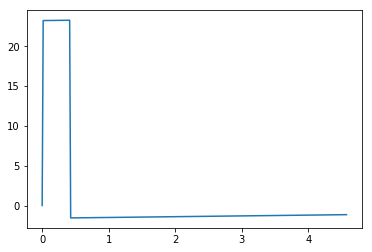

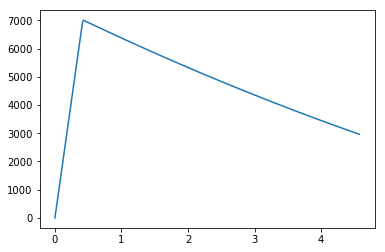

In [12]:
xs= np.linspace(-1e-6, L_mast.toval(ounit='m')+1e-6, 300)
Fsf= sym.lambdify(x,F_expr_mast.toval(ounit='N'), ['numpy','sympy'])
Fs= mg(np.array([Fsf(x) for x in xs]),'N')
Vs= Fs/annularArea(OD=OD_mast, ID=ID_mast)
plt.plot(xs, Vs.toval(ounit='MPa'))
print(F_d_mast, F_p_baseReact, F_p_legsReact, F_p_legsDrag, F_p_boom, sep='\n')
Msf= sym.lambdify(x, M_expr_mast.toval(ounit='N m'), ['numpy', 'sympy'])
Ms= mg(np.array([Msf(x) for x in xs]),'N m')
plt.figure()
plt.plot(xs, Ms.toval(ounit='N m'))
sigmas= Ms*(OD_mast/mg(2))/I_mast
plt.figure()
plt.plot(xs, sigmas.toval(ounit='MPa'))

In [ ]:
#OD_mast_new= 
#ID_mast_new= 

In [13]:
print(D_wind.ounit('lbf'))
print(Lz_CoP.ounit('ft'))
print(m_ballast.ounit('lbm'))

436.5993 lbf
12.7383 ft
175.0440 lbm


Okay, so, I totally forgot about the "armpit" beams that fix the legs at a particular angle. But, those don't really matter too much, since they're only going to make things worse. The takeaway is that we'd need to add an excessive amount of ballast to the feet (more than doubling their mass), which means we need a different design of ground station (pole on a plate, or something). 

It looks like the mast will still need some sort of reinforcement, since it's (currently) way under-built for a 100 mph load. 

$
My_{tip} = 0\\
0 = Fx_{windCR}*Hz_{CoP} - Fg*Lx_{leg} \\
Fx_{windCR} = \frac{Fg*Lx_{leg}}{Hz_{CoP}}
$